In [494]:
import numpy as np
import sys
from scipy.integrate import odeint
from scipy.integrate import ode

%matplotlib notebook


sys.path.append('../scripts')

In [495]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [496]:
from elements import *
import measurement as me

In [497]:
import matplotlib.pyplot as plt
%matplotlib notebook

## Time Domain Simulation of a Simple Cavity


In [498]:
omega_c = 5e9*np.pi*2
kappa_ex = 0.83e6*np.pi*2
kappa_0 = 0.41e6*np.pi*2
kappa = kappa_ex + kappa_0

In [507]:
Delta = 0.0 * kappa
s_x = 1
s_y = 1

M = np.array([[-kappa/2, Delta],[-Delta, -kappa/2]])
L_ex = np.array([[np.sqrt(kappa_ex), 0],[0, np.sqrt(kappa_ex)]])

W = 2 * 20 *kappa
N_s = 401
#fs = 10 * W/2/np.pi
fs = 1e9
dW = W / N_s
omega_ps = np.linspace(-W/2,W/2, N_s)    
S = np.zeros_like(omega_ps)*(1. + 0.0*1j)

for i, omega_p in enumerate(omega_ps):
    def model(a, t):
        a_in = np.array([s_x * np.cos(omega_p*t), s_y * np.sin(omega_p*t)])
        dadt = M @ a + L_ex @ a_in
        return dadt
    t1 = 2*np.pi*10/kappa
    t2 = np.min([2*np.pi*50/(np.abs(omega_p)+1e-1), 2*np.pi*50/(0.001*kappa)])
    T = t1 + t2
    N = 10*int(fs * T)
    t = np.linspace(0, T, N)
    a_0 = np.array([0, 0])
    a = odeint(model, a_0, t)
    #fs = N/T
    N_f = int(fs * t2)
    A = 2 * np.fft.fft( (a[-N_f:,0] + 1j * a[-N_f:,1])/np.sqrt(2) ) / N_f
    i_peak = np.abs(A) == max(np.abs(A))
    S[i] = A[i_peak] / np.sqrt(s_x**2 + s_y**2)

<IPython.core.display.Javascript object>


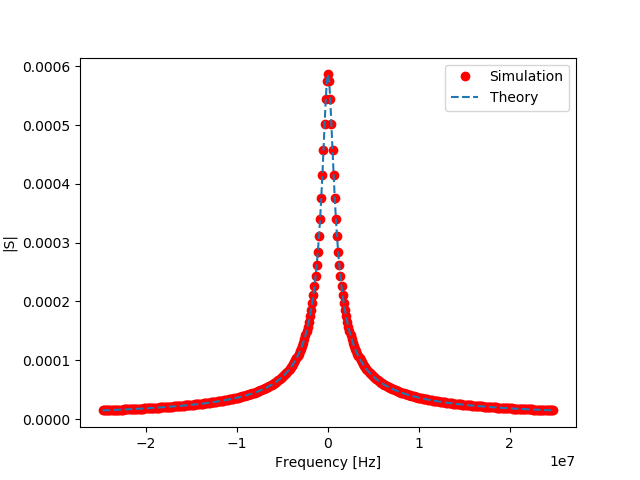

<IPython.core.display.Javascript object>


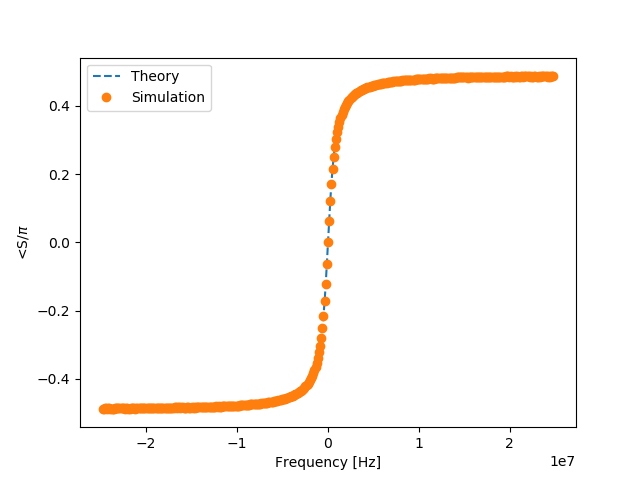

20.161290322580648


In [508]:
S_th = np.sqrt(kappa_ex) / (kappa/2 - 1j * (Delta + omega_ps) )

plt.figure()
plt.plot(omega_ps/2/np.pi, np.abs(S), 'o', color = 'red', label = 'Simulation')
plt.plot(omega_ps/2/np.pi, np.abs(S_th), linestyle = '--', label = 'Theory')
plt.xlabel('Frequency [Hz]')
plt.ylabel('|S|')
plt.legend()

plt.figure()
plt.plot(omega_ps/2/np.pi, np.angle(S_th)/np.pi, linestyle = '--')
plt.plot(omega_ps/2/np.pi, -np.angle(S)/np.pi, 'o')

print(2*np.pi*fs/W)
plt.legend(['Theory','Simulation'])
plt.xlabel('Frequency [Hz]')
plt.ylabel('<S/$\pi$');

### IOpy

In [509]:
a = Mode('a', omega_c)
a_inex = Input('ex', a, kappa_ex, kind = 'drive', omega_drive = omega_c, bath_temp=30000e-1)
a_in0 = Input('0', a, kappa_0, kind = 'bath', bath_temp=1000e0)
sys_cav = System([a], [a_in0,  a_inex], [])
a_outex = Output(sys_cav, a_inex)
omegas_newex, S_out_IOpy = me.linear_response(omega_c+omega_ps, sys_cav, a_outex, a_inex, plot = 0)

<IPython.core.display.Javascript object>


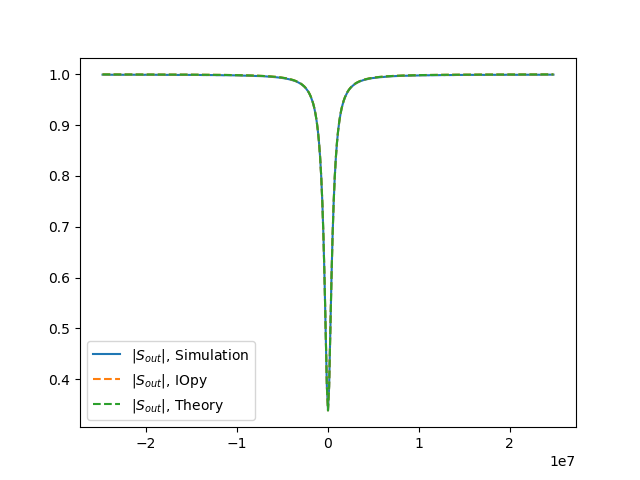

<IPython.core.display.Javascript object>


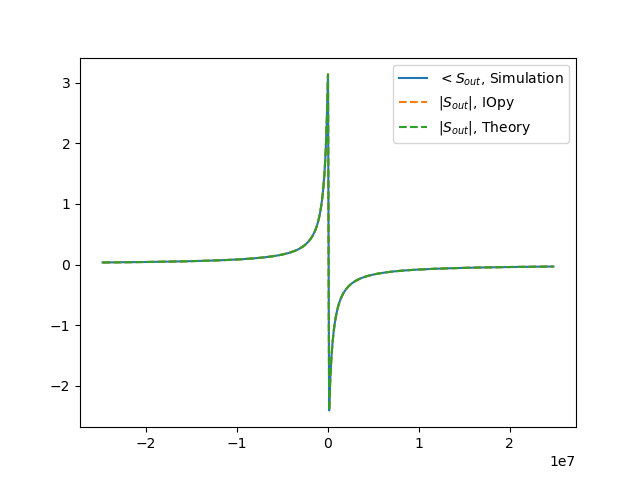

In [510]:

S_out = 1 - np.sqrt(kappa_ex) * S

S_out_theory = 1 - kappa_ex / (kappa/2 - 1j * (Delta + omega_ps) )

plt.figure()
plt.plot(omega_ps/2/np.pi, np.abs(S_out), label = '|$S_{out}$|, Simulation')
plt.plot(omega_ps/2/np.pi, np.abs(S_out_IOpy),label = '|$S_{out}$|, IOpy', linestyle = '--')
plt.plot(omega_ps/2/np.pi, np.abs(S_out_theory),label = '|$S_{out}$|, Theory', linestyle = '--')
plt.legend()

plt.figure()
plt.plot(omega_ps/2/np.pi, -np.angle(S_out),label = '$<S_{out}$, Simulation')
plt.plot(omega_ps/2/np.pi, np.angle(S_out_IOpy),label = '|$S_{out}$|, IOpy', linestyle = '--')
plt.plot(omega_ps/2/np.pi, np.angle(S_out_theory),label = '|$S_{out}$|, Theory', linestyle = '--')
plt.legend()

<IPython.core.display.Javascript object>


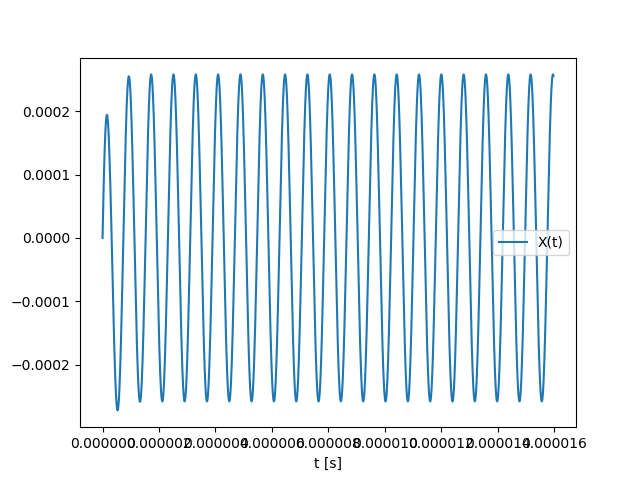

<IPython.core.display.Javascript object>


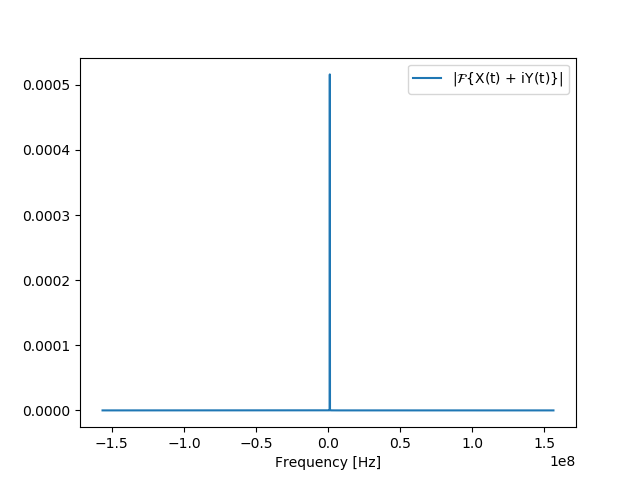

<IPython.core.display.Javascript object>


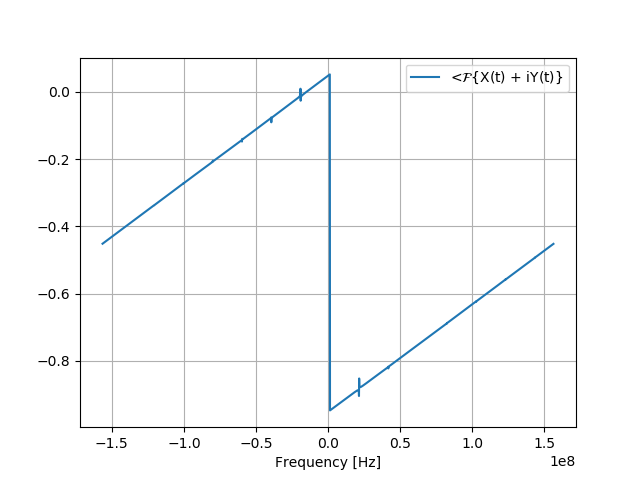

In [337]:
omega_p = 1*kappa + 10*kappa/500
def model(a, t):
        a_in = np.array([s_x * np.cos(omega_p*t), s_y * np.sin(omega_p*t)])
        dadt = M @ a + L_ex @ a_in
        return dadt
    
a_0 = np.array([0, 0])

N=5000
t1 = 2*np.pi*10/kappa
t2 = np.min([2*np.pi*10/(np.abs(omega_p)+1e-1), 2*np.pi*10/(0.001*kappa)])
T = t1 + t2
t = np.linspace(0, T, N)
a_in = np.array([np.cos(omega_p*t), np.sin(omega_p*t)])
a = odeint(model, a_0, t)

plt.figure()
plt.plot(t, a[:,0], label = 'X(t)')
plt.xlabel('t [s]')
plt.legend()

### Fourier Analysis

fs = N/T
N_f = int(fs * t2)
freqs = np.fft.fftfreq(N_f) * fs
A = 2 * np.fft.fft(a[-N_f:,0] + 1j * a[-N_f:,1]) / N_f



plt.figure()
plt.plot(np.fft.fftshift(freqs), np.abs(np.fft.fftshift(A)), label = '|$\mathcal{F}${X(t) + iY(t)}|')
plt.xlabel('Frequency [Hz]')
plt.legend()
i = np.abs(A) == max(np.abs(A))
plt.figure()
plt.plot(np.fft.fftshift(freqs), np.angle(np.fft.fftshift(A))/np.pi, label = '<$\mathcal{F}${X(t) + iY(t)}')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.grid()
